In [ ]:
#THIS SCRIPT WILL MAKE INTEGRATED SEURAT OBJECT WITH STANDARD WORKFLOW, WITHOUT PROTOPLAST INDUCED 
#GENES, OR MITO/CP GENES IN THE VARIABLE FEATURE LIST. ALSO TAKE OUT LOW QUALITY GENES (THOSE WITH MT > 10%)
#THIS INTEGRATES WT AND MUTANT

In [ ]:
if (!requireNamespace("BiocManager", quietly = TRUE))
    install.packages("BiocManager")
if (!requireNamespace("here", quietly = TRUE))
    install.packages("here")
if (!requireNamespace("ggplot2", quietly = TRUE))
    install.packages("ggplot2")
if (!requireNamespace("ggpointdensity", quietly = TRUE))
    install.packages("ggpointdensity")
if (!requireNamespace("DropletUtils", quietly = TRUE)) 
    BiocManager::install("DropletUtils")
if (!requireNamespace("BUSpaRse", quietly = TRUE)) 
    BiocManager::install("BUSpaRse")
if (!requireNamespace("scico", quietly = TRUE))
    install.packages("scico")
if (!requireNamespace("reticulate", quietly = TRUE))
    install.packages("reticulate")
if (!requireNamespace("future", quietly = TRUE))
    install.packages("future")
if (!requireNamespace("DoubletFinder", quietly = TRUE))
    remotes::install_github('chris-mcginnis-ucsf/DoubletFinder')
if (!requireNamespace("tidyverse", quietly = TRUE))
    install.packages("tidyverse")
#devtools::install_github(repo = 'satijalab/seurat', ref = 'develop')
# if (!requireNamespace("COPILOT", quietly = TRUE))
#     devtools::install_github('Hsu-Che-Wei/COPILOT')

In [ ]:
library(BUSpaRse)
library(here)
library(Matrix)
library(tidyverse)
library(Seurat)
library(ggpointdensity)
library(scico)
library(scales)
library(DropletUtils)
library(reticulate)
library(repr)
library(DoubletFinder)
library(future)
options(future.globals.maxSize = 100000 * 1024^2)

proto_genes=read.csv("../data/bulk_data/protoplasting.csv")
proto_list=as.character(proto_genes[abs(proto_genes$logFC) > 2,]$genes)

In [2]:
wt_1_seu = readRDS(file = "../data/seurat1/sc_26_seu_1.rds")
wt_2_seu = readRDS(file = "../data/seurat1/sc_67_seu_1.rds")
mut_1_seu = readRDS(file = "../data/seurat1/sc_27_seu_1.rds")
mut_2_seu = readRDS(file = "../data/seurat1/sc_68_seu_1.rds")

In [18]:
#deal with high mito cells

wt_1_seu <- subset(wt_1_seu, subset = percent.mito < 10)
dim(wt_1_seu@assays$RNA)

wt_2_seu <- subset(wt_2_seu, subset = percent.mito < 10)
dim(wt_2_seu@assays$RNA)

mut_1_seu <- subset(mut_1_seu, subset = percent.mito < 10)
dim(mut_1_seu@assays$RNA)

mut_2_seu <- subset(mut_2_seu, subset = percent.mito < 10)
dim(mut_2_seu@assays$RNA)


[1] 22866  8024

[1] 22906  7833

[1] 22518 11884

[1] 22641  7868

In [ ]:
all_intd_std = std_integrate(wt_1_seu, wt_2_seu, mut_1_seu, mut_2_seu, filename = "std_intd_all_5_mt_removed_minus_protos_mt_cp", nfeatures = 3000)

In [ ]:
all_intd_std = readRDS("../data/intd_seu_objects/std_intd_all_4_minus_protos_mt_cp.rds")

In [ ]:
DefaultAssay(all_intd_std) <- "integrated"
options(repr.plot.width=12, repr.plot.height=12)
# Run the standard workflow for visualization and clustering
all_intd_std <- ScaleData(all_intd_std, verbose = FALSE)
all_intd_std <- RunPCA(all_intd_std, npcs = 30, verbose = FALSE)
#From RunPCA doc: Features to compute PCA on. If features=NULL, PCA will be run using the variable features for the Assay. 
#Note that the features must be present in the scaled data. Any requested features that are not scaled or have 0 variance 
#will be dropped, and the PCA will be run using the remaining features.

all_intd_std <- FindNeighbors(all_intd_std, dims = 1:10)
all_intd_std <- FindClusters(all_intd_std, resolution = 0.3)
all_intd_std <- RunUMAP(all_intd_std, reduction = "pca", dims = 1:30)

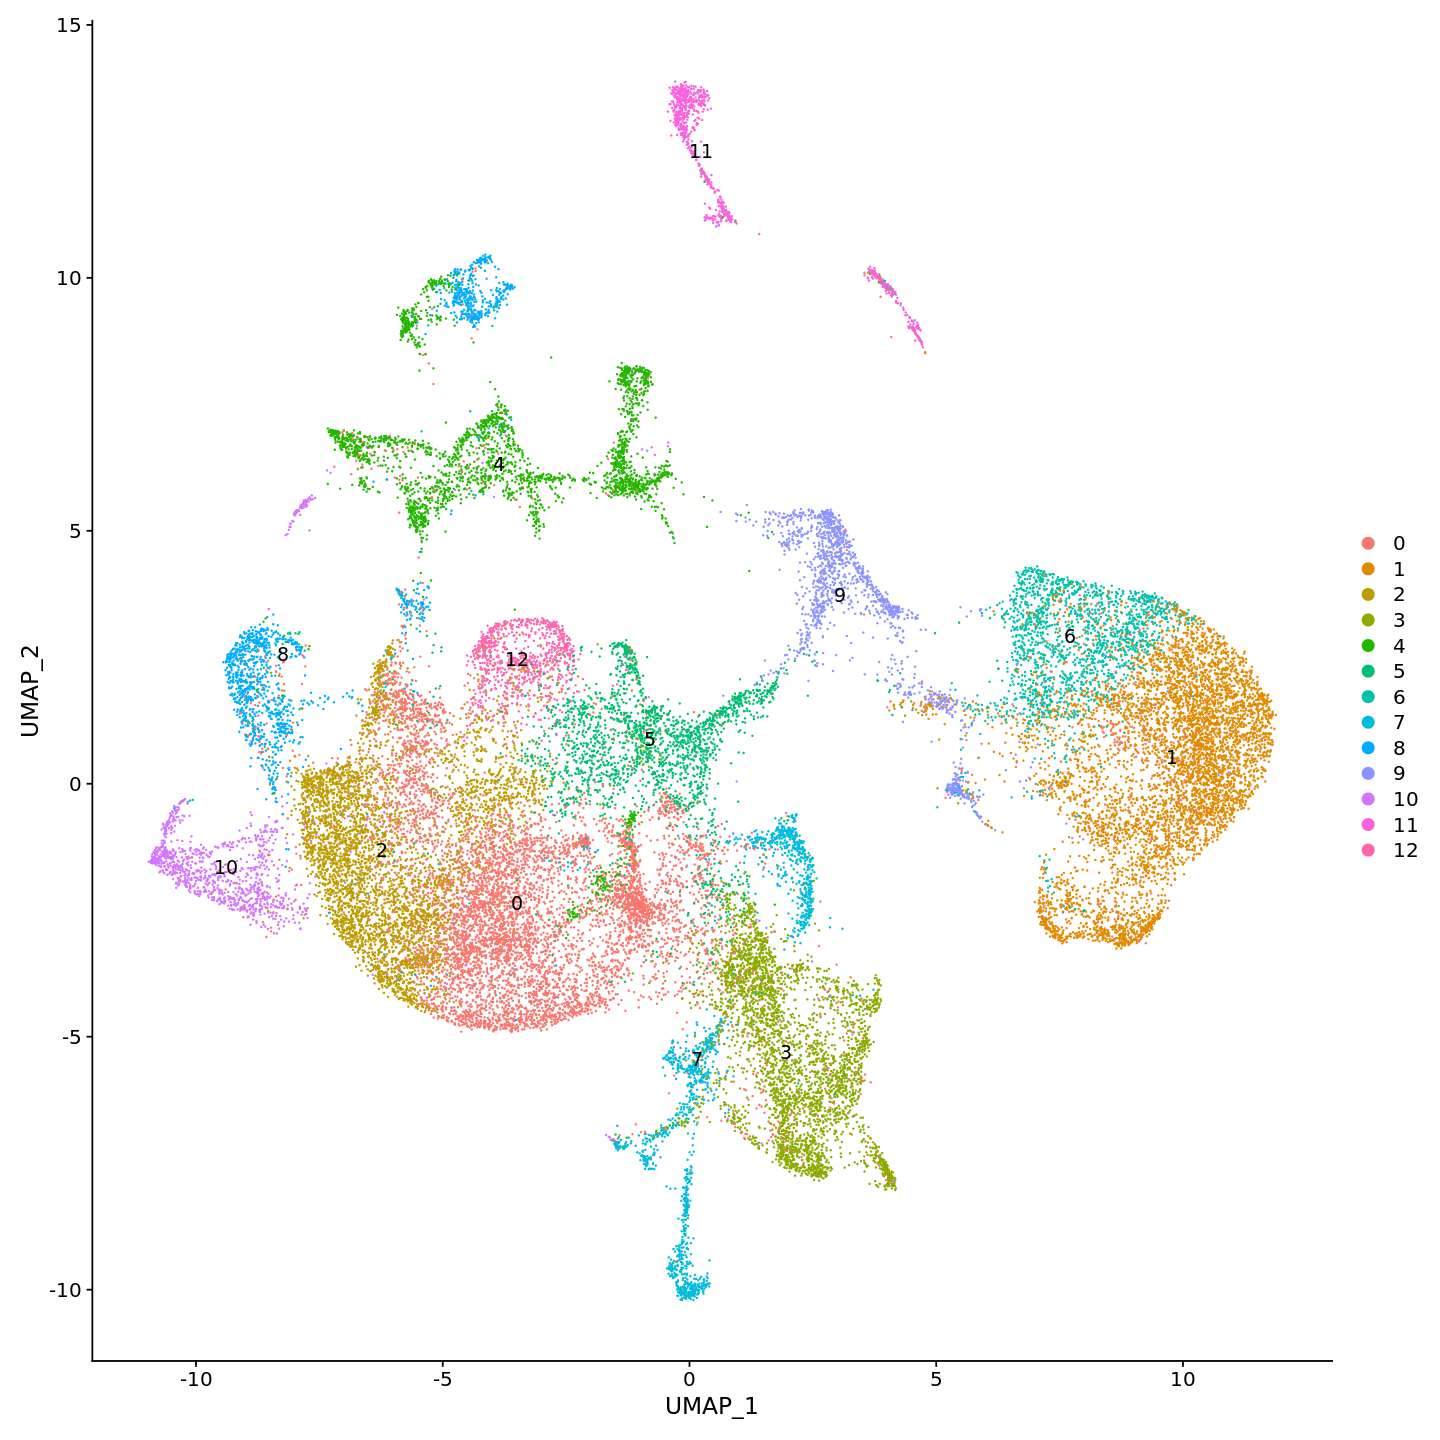

In [28]:
DimPlot(all_intd_std, reduction = "umap", label = TRUE)

In [30]:
all_intd_std@meta.data$orig.ident = c(rep("WT_1",length(colnames(wt_1_seu@assays$RNA))), rep("WT_2",length(colnames(wt_2_seu@assays$RNA))), rep("MUT_1",length(colnames(mut_1_seu@assays$RNA))), rep("MUT_2",length(colnames(mut_2_seu@assays$RNA))))

In [31]:
table(Idents(all_intd_std), all_intd_std$orig.ident)

    
     MUT_1 MUT_2 WT_1 WT_2
  0   3005  1691 1327 1338
  1   1235  1347 1621 1574
  2   1601   914  973  987
  3   1168   966  707  798
  4    937   700  559  573
  5    841   420  536  412
  6    463   320  515  477
  7    619   394  284  351
  8    478   352  338  382
  9    405   204  561  314
  10   437   214  210  255
  11   381   187  150  195
  12   314   159  243  177

In [32]:
wt_1_pb <- rowSums(as.matrix(GetAssayData(subset(all_intd_std, subset = orig.ident == "WT_1"), slot = "counts")[, WhichCells(subset(all_intd_std, subset = orig.ident == "WT_1"), ident = "9")]))
wt_2_pb <- rowSums(as.matrix(GetAssayData(subset(all_intd_std, subset = orig.ident == "WT_2"), slot = "counts")[, WhichCells(subset(all_intd_std, subset = orig.ident == "WT_2"), ident = "9")]))
mut_1_pb <- rowSums(as.matrix(GetAssayData(subset(all_intd_std, subset = orig.ident == "MUT_1"), slot = "counts")[, WhichCells(subset(all_intd_std, subset = orig.ident == "MUT_1"), ident = "9")]))
mut_2_pb <- rowSums(as.matrix(GetAssayData(subset(all_intd_std, subset = orig.ident == "MUT_2"), slot = "counts")[, WhichCells(subset(all_intd_std, subset = orig.ident == "MUT_2"), ident = "9")]))

In [33]:
all_pb = cbind (wt_1_pb, wt_2_pb, mut_1_pb, mut_2_pb)
colnames(all_pb) = c("wt_1_pb", "wt_2_pb", "mut_1_pb", "mut_2_pb")

In [36]:
all_pb_bad_norm = all_pb
all_pb_bad_norm[,1] = all_pb[,1]/colSums(all_pb)[1] 
all_pb_bad_norm[,2] = all_pb[,2]/colSums(all_pb)[2] 
all_pb_bad_norm[,3] = all_pb[,3]/colSums(all_pb)[3] 
all_pb_bad_norm[,4] = all_pb[,4]/colSums(all_pb)[4] 
all_pb_bad_norm = all_pb_bad_norm * 1000000

In [37]:
all_pb_bad_norm[c("AT1G61820","AT4G23500","AT1G71380","AT4G30290","AT3G59850","AT4G25810","AT3G60140","AT1G22880","AT3G07970",
"AT4G18340","AT2G41850"),]

all_pb_bad_norm[c("AT4G28490", "AT5G65710","AT1G68765", "AT1G71830","AT2G41850", "AT3G07970", "AT5G03280","AT4G08150", "AT3G45640","AT2G43790"),]

,wt_1_pb,wt_2_pb,mut_1_pb,mut_2_pb
AT1G61820,39.080413,17.154778,26.483482,31.0137967
AT4G23500,40.098133,33.875258,8.827827,8.8610848
AT1G71380,395.078555,506.608824,19.013782,110.7635597
AT4G30290,238.349813,401.074367,106.612993,130.2579462
AT3G59850,104.621523,150.918617,15.618464,22.1527119
AT4G25810,187.870946,366.547662,192.854077,262.2881093
AT3G60140,5.902771,5.863025,40.743819,0.8861085
AT1G22880,10.991366,7.817367,4.074382,3.5444339
AT3G07970,341.139442,287.505393,22.409101,27.4693628
AT4G18340,73.479319,80.128014,23.088164,19.4943865


,wt_1_pb,wt_2_pb,mut_1_pb,mut_2_pb
AT4G28490,439.65465,321.380651,266.192952,211.779926
AT5G65710,29.92094,9.120262,6.790637,5.316651
AT1G68765,36.63789,32.789512,27.162546,10.633302
AT1G71830,77.34665,36.915345,22.409101,2.658325
AT2G41850,517.40839,732.009578,152.110258,95.699716
AT3G07970,341.13944,287.505393,22.409101,27.469363
AT5G03280,26.05361,15.634734,15.618464,9.747193
AT4G08150,19.74375,7.600218,8.148764,2.658325
AT3G45640,25.85007,14.983287,57.041347,23.924929
AT2G43790,86.70967,65.579025,71.980747,66.458136


In [40]:
all_pb_bad_norm["AT4G27230",]

wt_1_pb  wt_2_pb mut_1_pb mut_2_pb 
55.97455 65.36188 18.33472 20.38049

In [38]:
write.csv(all_pb, file = "../data/counts/flowers_5")

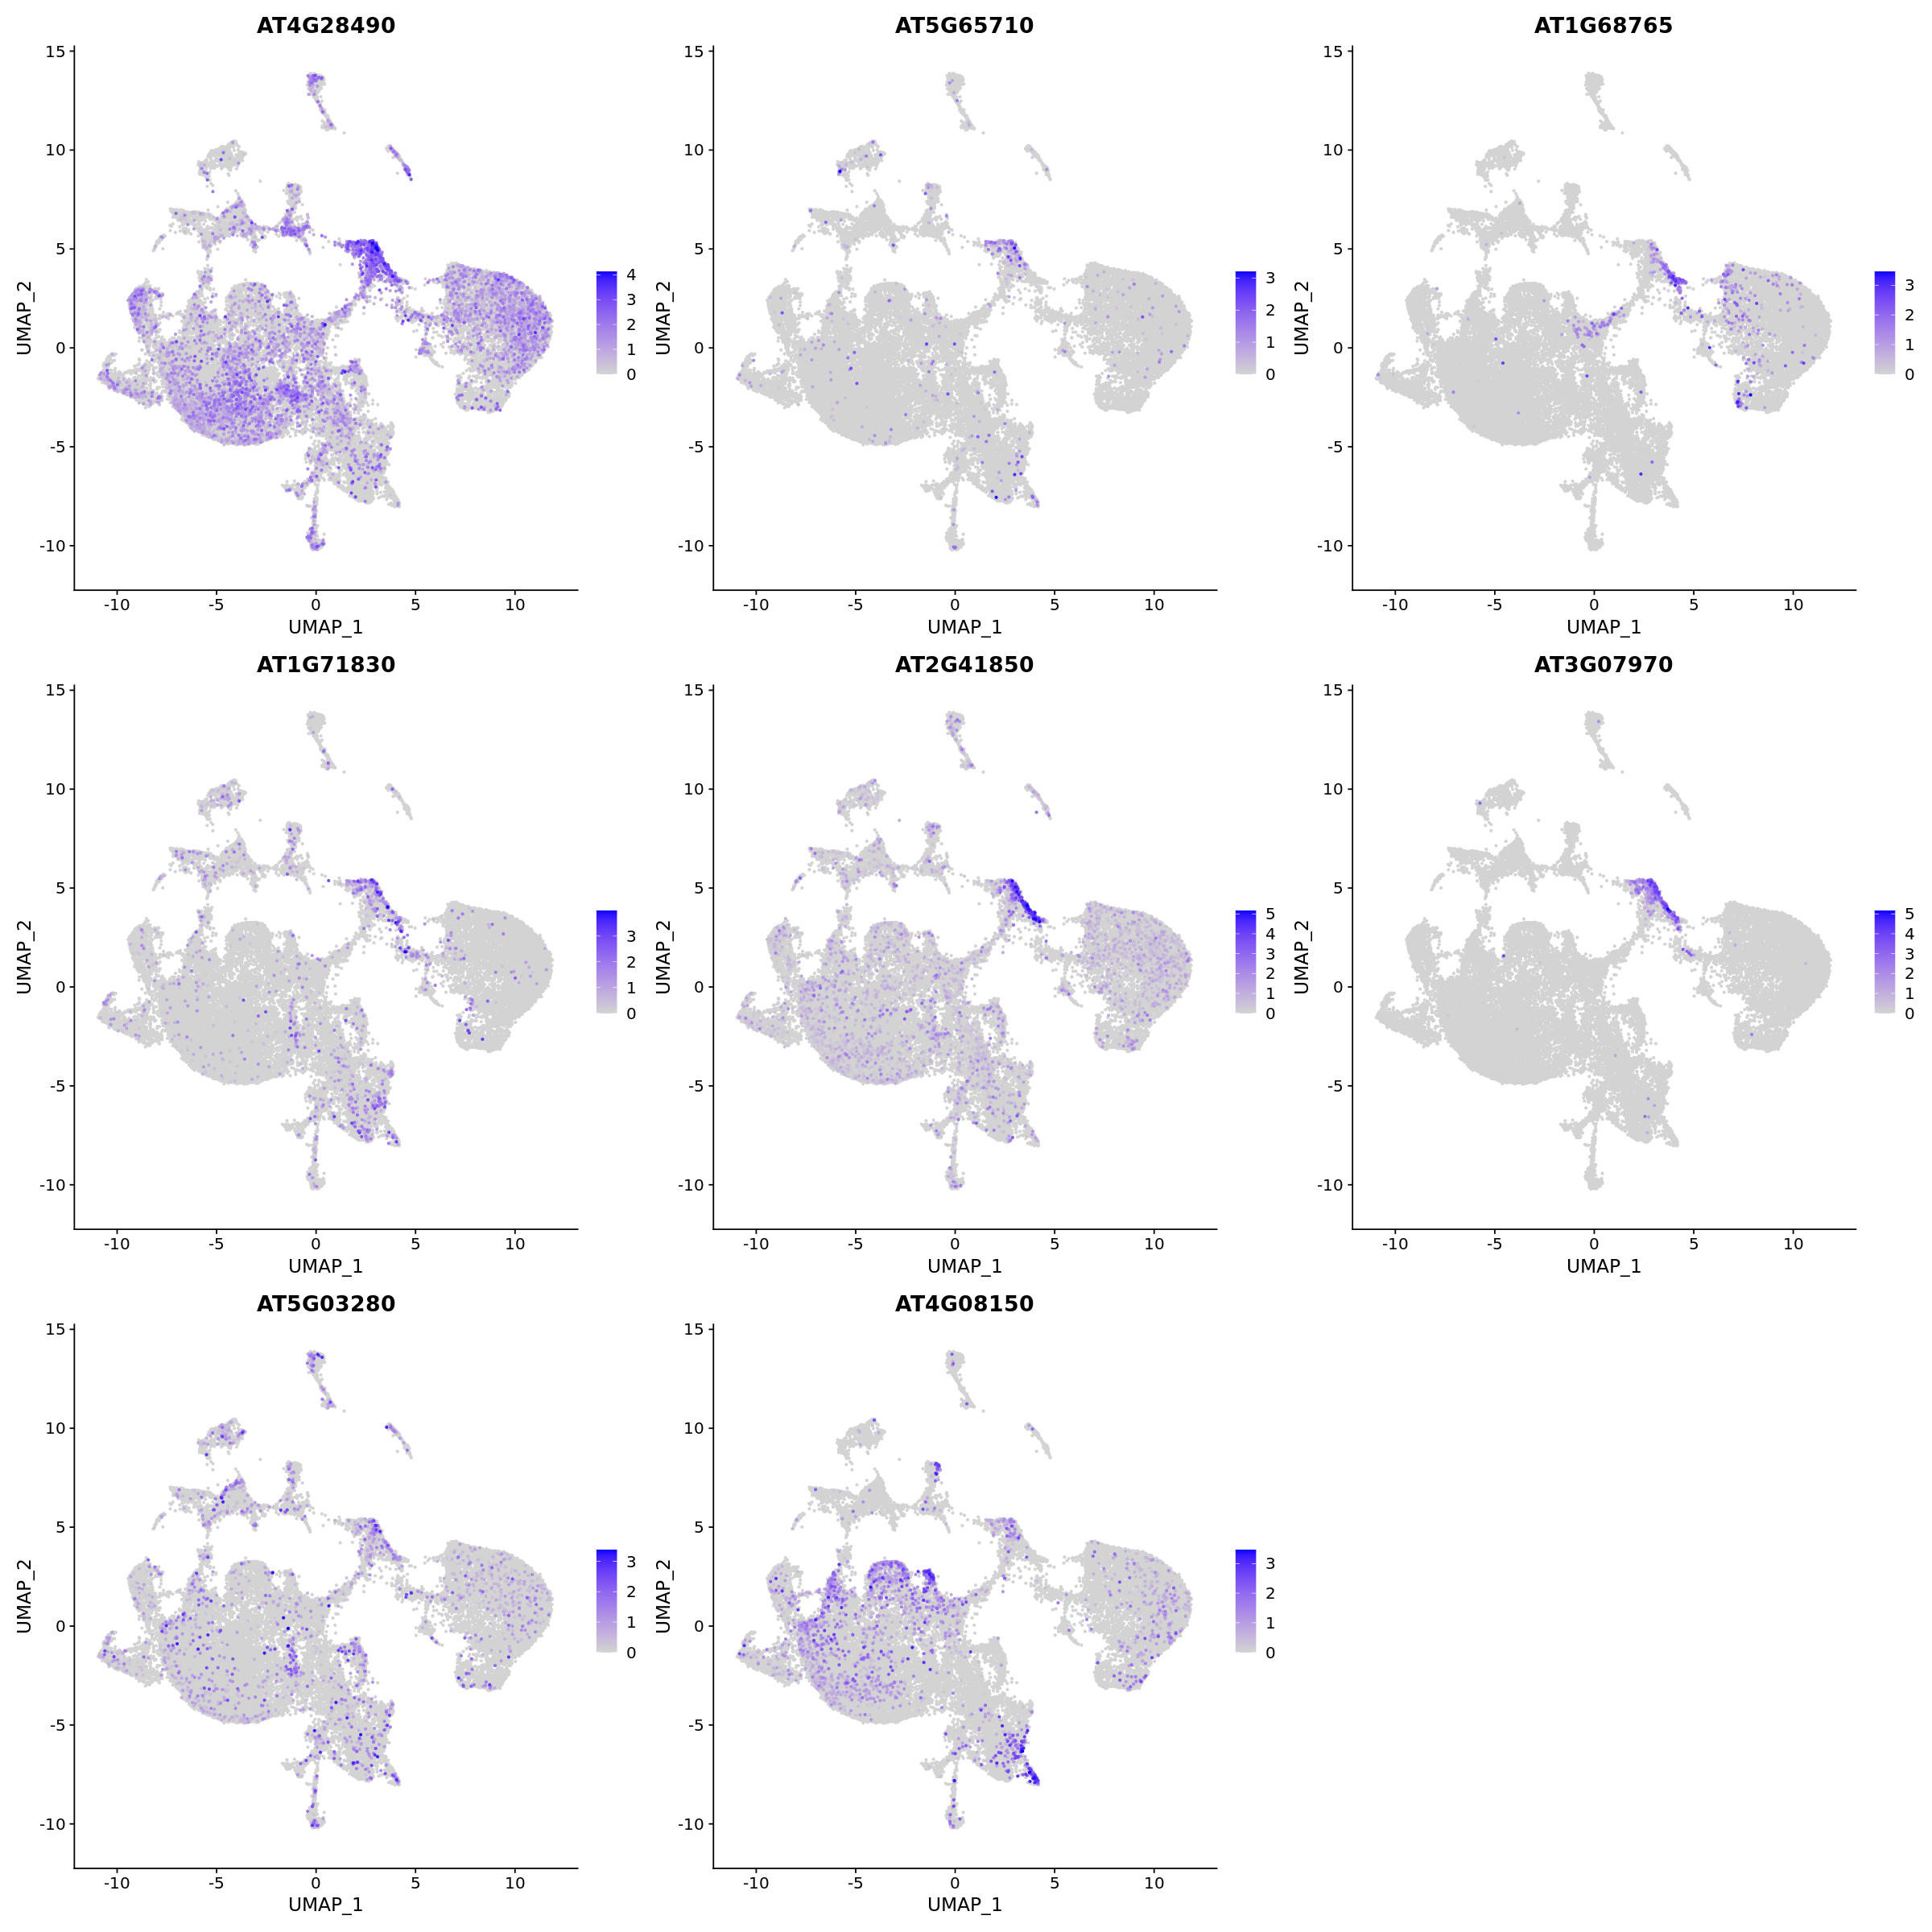

In [29]:
options(repr.plot.width=20, repr.plot.height=20)
all_intd_std@active.assay = "RNA"
FeaturePlot(all_intd_std, features = c("AT4G28490", "AT5G65710","AT1G68765", "AT1G71830","AT2G41850", "AT3G07970", "AT5G03280","AT4G08150"),  pt.size = .5, slot = "data", order = TRUE)

In [109]:
saveRDS(all_intd_std, "../data/intd_seu_objects/std_intd_all_4_minus_protos_mt_cp.rds")

In [22]:
#takes a list of Seurat objects and performs standard integration
std_integrate <- function(..., filename, nfeatures) {
    obj.list <- list(...) # THIS WILL BE A LIST STORING EVERYTHING:
    
    for (i in 1:length(obj.list)) {
        obj.list[[i]] <- NormalizeData(obj.list[[i]], verbose = FALSE)
        obj.list[[i]] <- FindVariableFeatures(obj.list[[i]], selection.method = "vst", nfeatures = nfeatures, verbose = FALSE)
        VariableFeatures(obj.list[[i]]) <-  VariableFeatures(obj.list[[i]])[!c(grepl("ATMG",VariableFeatures(obj.list[[i]])) | grepl("ATCG",VariableFeatures(obj.list[[i]])) | (VariableFeatures(obj.list[[i]]) %in% proto_list))]
    }
    
    rc.anchors <- FindIntegrationAnchors(object.list = obj.list, dims = 1:30)
    rc.integrated <- IntegrateData(anchorset = rc.anchors, dims = 1:30)
    
    #save object    
    saveRDS(rc.integrated, file = paste("../data/intd_seu_objects/",filename,".rds", sep = ""))
    return(rc.integrated)
}
